In [141]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
aru1 = np.load('ARU05_20111224_170000_channel1.npy')

In [6]:
aru.shape

(129, 257143)

In [4]:
aru2 = np.load('ARU05_20111224_170000_channel2.npy')

In [10]:
aru2.shape

(129, 257143)

In [22]:
aru1[:, :500].shape

(129, 500)

In [29]:
aru1.shape[1] / 129

1993.3565891472867

In [55]:
stepsize = 65

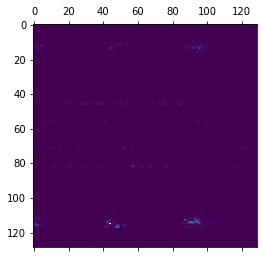

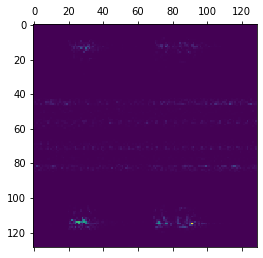

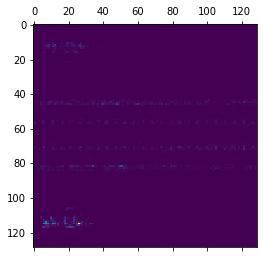

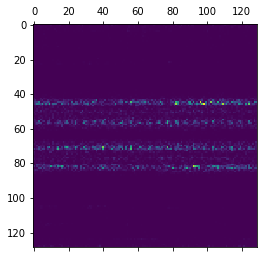

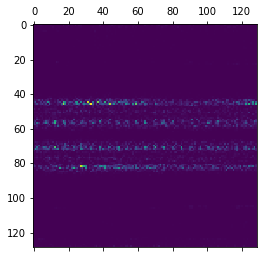

In [56]:
for _ in range(5):
    plt.matshow(aru1[:, 0+(_*stepsize):129+(_*stepsize)])

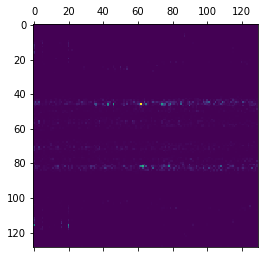

In [30]:
plt.matshow(aru2[:, ::1993])

## Implementing Autoencoder

https://gist.github.com/AFAgarap/4f8a8d8edf352271fa06d85ba0361f26

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader

import os

import numpy as np

In [65]:
class SpectrogramDatasetLoader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, width, stepsize, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        #self.transform = transform
        self.spectrograms = [f for f in os.listdir(root_dir)]
        self.width = width
        self.stepsize = stepsize

    def __len__(self):
        #return len(self.landmarks_frame)
        # return number of files in the root folder
        return len(self.spectrograms)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.spectrograms[idx])
        #image = io.imread(img_name)
        image = np.load(img_name)
        # slicing the spectrogram
        #image = image[:, start:end]
#         sample = {'image': image}

        #if self.transform:
        #    sample = self.transform(sample)

        return torch.tensor(image)

In [66]:
data = SpectrogramDatasetLoader('/home/hunaid/lucidmonkeys/spectrograms/')

In [63]:
# data[1]

In [128]:
# class AE(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
#         self.layers = {}
        
#         self.layers.update( {'relu' : nn.Linear(
#             in_features=kwargs["input_shape"], out_features=70
#         )} )
        
#         self.layers.update( {'sigmoid' : nn.Linear(
#             in_features=70, out_features=20
#         )} )
        
#         self.layers.update( {'relu' : nn.Linear(
#             in_features=20, out_features=70
#         )} )
        
#         self.layers.update( {'sigmoid' : nn.Linear(
#             in_features=70, out_features=kwargs["input_shape"]
#         )} )

#     def forward(self, features):
#         for k, v in self.layers.values():
#             if k == 'relu': activation = torch.relu( v(features) )
#             if k == 'tanh': activation = torch.tanh( v(features) )
#             if k == 'sigmoid': activation = torch.sigmoid( v(features) )
        
#         return activation
    
#     def parameters(self):
#         return self.layers.values()

In [131]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=100
        )
        self.encoder_output_layer = nn.Linear(
            in_features=70, out_features=30
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=30, out_features=70
        )
        self.decoder_output_layer = nn.Linear(
            in_features=70, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [177]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(129 * 129, 100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 100),
            nn.ReLU(True), nn.Linear(100, 129 * 129), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [127]:
model.parameters()

<generator object Module.parameters at 0x7fe396811f20>

In [126]:
? torch.nn.Module.parameters

In [173]:
batch_size = 512
epochs = 20
learning_rate = 1e-1

In [181]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
# model = AE(input_shape=129).to(device)
model = autoencoder().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [153]:
# plt.matshow(model(spectrogram[:, 0+(_*stepsize):129+(_*stepsize)]).detach().numpy())

In [182]:
for epoch in range(epochs):
    loss = 0
    stepsize = 129
    
    for spectrogram in data:
        chops = int(spectrogram.shape[1] / stepsize)
        for _ in range(chops):
            # reshape mini-batch data to [N, 784] matrix
            # load it to the active device
            #batch_features = batch_features.view(-1, 784).to(device)
            snippet = spectrogram[:, 0+(_*stepsize):129+(_*stepsize)]
            snippet = torch.reshape(snippet, (-1,))

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(snippet)

            # compute training reconstruction loss
            train_loss = criterion(outputs, snippet)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
            
    # compute the epoch training loss
    loss = loss / len(data)

    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 60769476.02441406
epoch : 2/20, recon loss = 60769364.51660156
epoch : 3/20, recon loss = 60769364.51660156
epoch : 4/20, recon loss = 60769364.51660156


KeyboardInterrupt: 